# 12. Finite Difference Schemes

----

Author: Milan Leonard u6661755


## Purpose

Explore numerical integration of partial differential equations through implementing the forward and backward (explicit or implicit) schemes and demonstrate numerical stability

## The specifics

Solve  

$$\frac{\partial u}{\partial t} - k \frac{\partial^2 u}{\partial x^2} = 0$$

using the FTCS approximation 
 
$$ u_j^{n+1} = u_j^n + \frac{k}{\Delta x^2}(u_{j+1}^n - 2u_j^n + u_{j-1}^n) $$

### Extension
Also implement the BTCS scheme


In [1]:
import numpy as np
import scipy.linalg

import matplotlib.pyplot as plt


from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML

In [2]:
def compute_ftcs(L, Nx, Nt, T, k, dt, dx):
    GridToFill = np.zeros(shape=(Nt,Nx)) #
    Analytic = np.zeros(shape=(Nt,Nx))
    GridToFill[0,:] = np.sin(np.pi * np.linspace(0,1,Nx)) # initialise
    Analytic[0,:] = np.sin(np.pi * np.linspace(0,1,Nx)) # initialise
    for i in np.arange(1,Nt):
        Analytic[i,:] = np.sin(np.pi * np.linspace(0,L,Nx)/L) * np.exp(- k * np.pi**2 * (i+1)*dt / L**2)
        for j in range(1,Nx-1):
            GridToFill[i,j] = GridToFill[i-1,j] + k * dt / dx**2 * (GridToFill[i-1,j-1] + GridToFill[i-1,j+1] - 2 * GridToFill[i-1,j])
    return Analytic, GridToFill

def compute_btcs(L, Nx, Nt, T, k, dt, dx, r):
    GridToFill = np.zeros(shape=(Nt,Nx)) #
    Analytic = np.zeros(shape=(Nt,Nx))
    GridToFill[0,:] = np.sin(np.pi * np.linspace(0,1,Nx)) # initialise
    Analytic[0,:] = np.sin(np.pi * np.linspace(0,1,Nx)) # initialise

    A = np.zeros((Nx, Nx)) # initialise the matrix we will need to solve
    b = np.zeros(Nx)

    for i in range(1, Nx-1): # A doesn't depend on t so we precompute
        A[i,i-1] = -r
        A[i,i+1] = -r
        A[i,i] = 1 + 2*r
    A[0,0] = A[Nx-1,Nx-1] = 1

    for i in np.arange(1, Nt):
        # Compute b and solve linear system 
        Analytic[i,:] = np.sin(np.pi * np.linspace(0,L,Nx)/L) * np.exp(- k * np.pi**2 * (i+1)*dt / L**2)
        b[:] = -GridToFill[i-1,:]
        b[0] = b[Nx-1] = 0
        GridToFill[i,:] = scipy.linalg.solve(A, b) # Use scipy to solve our system of linear equations
    return Analytic, GridToFill


In [3]:
def make_and_save_ani(fname, L, Nx, Nt, T, k, method='forward'):
    dt = T / Nt
    dx = L / Nx
    # Here we compute r -- using von neumann stability analysis we know that if r < 0.5 then it is numerically stable
    r = k*dt/dx**2
    print(r)
    if method=='forward':
        Analytic, GridToFill = compute_ftcs(L, Nx, Nt, T, k, dt, dx)
    elif method=='backward':
        Analytic, GridToFill = compute_btcs(L, Nx, Nt, T, k, dt, dx, r)
    fig, [ax1,ax2] = plt.subplots(1,2, figsize=(12, 8))
    fig.suptitle(f"r={r:.2f}")
    line1,  = ax1.plot(GridToFill[0,:])
    line2,  = ax2.plot(Analytic[0,:])
    line = [line1,line2]
    ax1.set_xlabel("FTCS")
    ax2.set_xlabel("Analytic expression")
    ax1.set_ylim(([0,1]))
    ax2.set_ylim(([0,1]))
    ax1.set_xlim(([0,L]))
    ax2.set_xlim(([0,L]))
    X = np.linspace(0,L,Nx)
    def animate(i):
        line[0].set_data(X,GridToFill[10*i,:])
        line[1].set_data(X,Analytic[10*i,:])
        return line
    ani = FuncAnimation(fig, animate, blit=True, frames=Nt//10, repeat=True, interval=1)
    html = ani.to_html5_video()
    ani.save(fname)
    return html

# Demonstration
We show that for r < 0.5 the numerical solution is stable and that it matches the analytic solution

0.4999999999999999


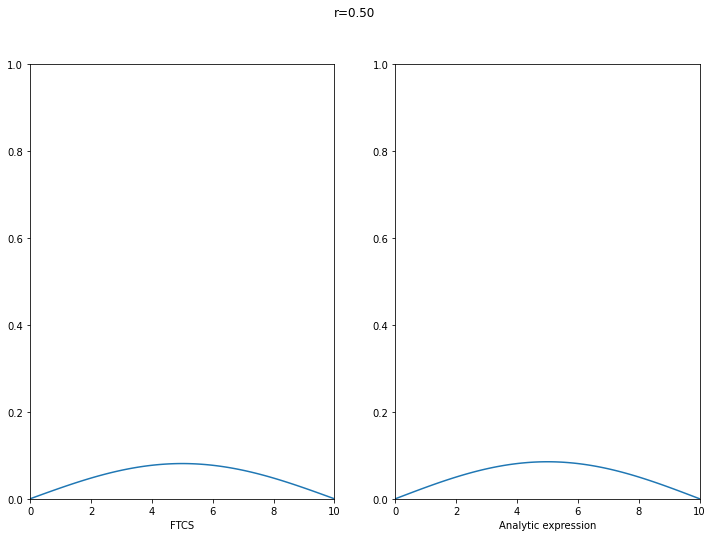

In [4]:
html = make_and_save_ani('stableftcs.gif', 10, 100, 5000, 50, 0.5)

In [5]:
HTML(html)

We now show that for even tiny bits above 0.5 the solution becomes unstable and diverges

0.510204081632653


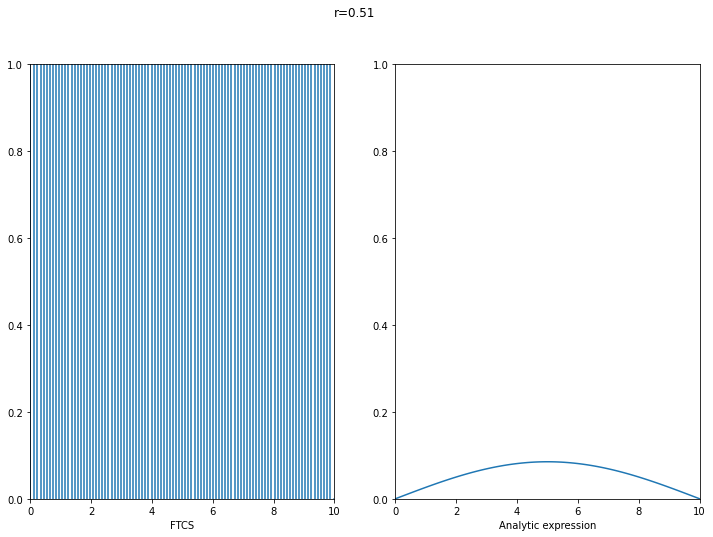

In [6]:
html = make_and_save_ani('unstableftcs.gif', 10, 100, 4900, 50, 0.5)

In [7]:
HTML(html)

And as r grows past 0.5 then the time for stability dramatically decreases
html = make_and_save_ani('unstableftcs.gif', 10, 100, 4900, 50, 0.5)

0.7999999999999998
<ipython-input-2-110332a76167>:9: RuntimeWarning: overflow encountered in double_scalars
  GridToFill[i,j] = GridToFill[i-1,j] + k * dt / dx**2 * (GridToFill[i-1,j-1] + GridToFill[i-1,j+1] - 2 * GridToFill[i-1,j])
<ipython-input-2-110332a76167>:9: RuntimeWarning: invalid value encountered in double_scalars
  GridToFill[i,j] = GridToFill[i-1,j] + k * dt / dx**2 * (GridToFill[i-1,j-1] + GridToFill[i-1,j+1] - 2 * GridToFill[i-1,j])


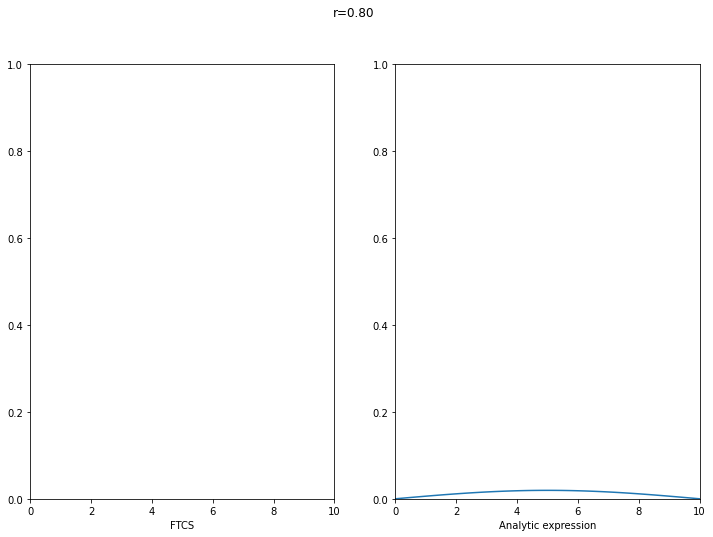

In [8]:
html = make_and_save_ani('veryunstableftcs.gif', 10, 100, 5000, 50, 0.8) # We see an overflow error rapidly

In [9]:
HTML(html)

0.4999999999999999


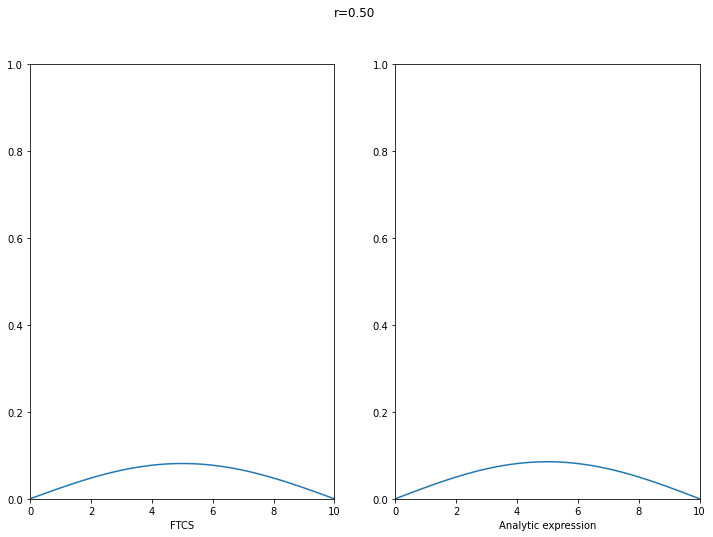

In [10]:
html = make_and_save_ani('btcs.gif', 10, 100, 5000, 50, 0.5, method='backward')

In [11]:
HTML(html)

4.999999999999999


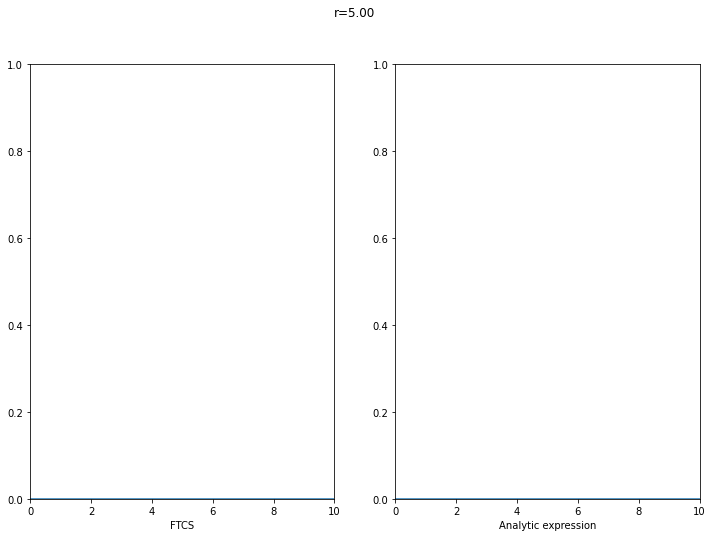

In [13]:
# And now for larger r
html = make_and_save_ani('btcsstableforlarger.gif', 10, 100, 5000, 50, 5, method='backward')

In [14]:
HTML(html)

# The cost of python and for loops

----

Whilst we should 100% expect that the FTCS approximation is significantly less computationally expensive, since I'm not doing any parallelization or vectorized operations and leaving the computation to python I suspect that it will actually take longer to compute the FTCS approx than the BTCS approx because scipy.linalg should be running compiled C and/or Fortran with vector operations using very quick algorithms, so I just wanted to test that here

In [15]:
L = 10
Nx = 100
dx = L / Nx
Nt = 5000
T = 50
dt = T/Nt
k = 0.5
r = k*dt/dx**2
print(r)

0.4999999999999999


In [16]:
%timeit compute_ftcs(L, Nx, Nt, T, k, dt, dx)

690 ms ± 4.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit compute_btcs(L, Nx, Nt, T, k, dt, dx, r)

1.18 s ± 35.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Turns out I was wrong even if they are on par, however I think because the A matrix we have to solve is a sparse matrix if we used scipy.sparse I'd bet good money it'd be a very close race

# Conclusion
- We have seen two methods of using finite difference schemes to solve the 1-D diffusion equation for a gaussian initial conditions and demonstrated the numerical stability of BTCS at the cost of extra computational complexity
- I performed both the base project and the extension 

# Potential future works
- Check for different initial conditions
- Extend to a 2-d or 3-d spatial dimension